In [83]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import itertools
from scipy import signal
from scipy import stats

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import accuracy_score

%matplotlib inline

In [84]:
#clean data
file = '~/galvanize/capstones/PredictingSearches-on-EDGAR/Logs/111001.csv'
df = pd.read_csv(file, names=['IP','Date','Time','Accession'])

In [85]:
Uniq = df.Accession.unique()
u = np.random.choice(Uniq, 100000)

In [86]:
df1 = df[df['Accession'].isin(u)]

In [87]:
df1 = df1.reset_index()

In [88]:
df1['Datetime'] = df1['Date'] + ' ' + df1['Time']
df1['Datetime'] = pd.to_datetime(df1['Datetime'])

In [89]:
df1.shape

(301654, 6)

In [90]:
df1 = df1.drop(['index','IP','Date','Time'],axis=1)

In [91]:
df1.set_index(df1.Datetime, inplace=True)

In [92]:
df1 = df1.drop('Datetime',axis=1)

In [11]:
#Feature Engineering
#df1['Counts_Hour'] = df1.groupby([df1.index.hour, df1.Accession]).cumcount()+1

In [93]:
df1['Counts'] = df1.groupby(df1.Accession).cumcount()+1

In [94]:
df1.head()

,Accession,Counts
Datetime,,
2011-10-01,0000866273-11-000010,1
2011-10-01,0001225208-10-013882,1
2011-10-01,0001225208-11-019351,1
2011-10-01,0000927089-09-000144,1
2011-10-01,0001225208-11-019351,2


In [95]:
df1.shape

(301654, 2)

In [96]:
#Dividing the dataframe to be able to aggregate data
df_totalsum = df1
df_before10 = df1

In [97]:
# Find Accession in df_y, then pop values to y
df_totalsum = df_totalsum.groupby([df1.Accession]).max()

In [98]:
df_totalsum.shape

(93517, 1)

In [99]:
stop = pd.Timestamp('2011-10-01 10:00:00')

In [100]:
df_before10 = df_before10[:stop]

In [101]:
df_before10.shape

(133561, 2)

In [102]:
df_before10 = df_before10.groupby([df_before10.Accession]).max()

In [103]:
df_before10.shape

(49355, 1)

In [104]:
df_before10.head()

,Counts
Accession,
0000000000-05-038958,2
0000000000-05-048603,1
0000000000-06-051095,2
0000000000-06-056446,1
0000000000-07-002032,1


In [105]:
df_before10 = df_before10.set_index('Accession')

KeyError: "None of ['Accession'] are in the columns"

In [106]:
df_totalsum = df_totalsum.set_index('Accession')

KeyError: "None of ['Accession'] are in the columns"

In [107]:
#Renaming Columns
df_totalsum['Total_Counts'] = df_totalsum['Counts']
df_totalsum = df_totalsum.drop('Counts', axis=1)
#df_totalsum['Counts'] = df_totalsum['Counts'].rename('Total_Counts')

In [108]:
df_totalsum = df_totalsum.reset_index()
df_before10 = df_before10.reset_index()
df_totalsum['cc'] = df_totalsum.groupby(df_totalsum.index).cumcount()
df_before10['cc'] = df_before10.groupby(df_before10.index).cumcount()

In [109]:
mer = df_before10.merge(df_totalsum, how='outer').drop('cc',axis=1)

In [110]:
mer.head()

,Accession,Counts,Total_Counts
0,0000000000-05-038958,2.0,2
1,0000000000-05-048603,1.0,1
2,0000000000-06-051095,2.0,2
3,0000000000-06-056446,1.0,1
4,0000000000-07-002032,1.0,1


In [111]:
docnames = mer.pop('Accession').values

In [112]:
mer.head()

,Counts,Total_Counts
0,2.0,2
1,1.0,1
2,2.0,2
3,1.0,1
4,1.0,1


In [ ]:
# X = data before 10 am

In [ ]:
# y = data after 10 am 

In [113]:
from sklearn.preprocessing import PolynomialFeatures

In [114]:
mer['Counts'] = mer['Counts'].fillna('0')

In [115]:
y = mer.pop('Total_Counts').values

In [116]:
mer['Counts'] = mer['Counts'].fillna(0)

In [117]:
mer.Counts = mer.Counts.astype('int') 

In [118]:
X = mer

In [119]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [120]:
polynomial_features= PolynomialFeatures(degree=2)
x_poly = polynomial_features.fit_transform(X_train)

model = LinearRegression()
model.fit(x_poly, y_train)
y_poly_pred = model.predict(x_poly)

In [121]:
from sklearn.metrics import mean_squared_error, r2_score
def create_polynomial_regression_model(degree):
  "Creates a polynomial regression model for the given degree"
  
  poly_features = PolynomialFeatures(degree=degree)
  
  # transforms the existing features to higher degree features.
  X_train_poly = poly_features.fit_transform(X_train)
  
  # fit the transformed features to Linear Regression
  poly_model = LinearRegression()
  poly_model.fit(X_train_poly, y_train)
  
  # predicting on training data-set
  y_train_predicted = poly_model.predict(X_train_poly)
  
  # predicting on test data-set
  y_test_predict = poly_model.predict(poly_features.fit_transform(X_test))
  
  # evaluating the model on training dataset
  rmse_train = np.sqrt(mean_squared_error(y_train, y_train_predicted))
  r2_train = r2_score(y_train, y_train_predicted)
  
  # evaluating the model on test dataset
  rmse_test = np.sqrt(mean_squared_error(y_test, y_test_predict))
  r2_test = r2_score(y_test, y_test_predict)
  
  print("The model performance for the training set")
  print("-------------------------------------------")
  print("RMSE of training set is {}".format(rmse_train))
  print("R2 score of training set is {}".format(r2_train))
  
  print("\n")
  
  print("The model performance for the test set")
  print("-------------------------------------------")
  print("RMSE of test set is {}".format(rmse_test))
  print("R2 score of test set is {}".format(r2_test))

In [122]:
create_polynomial_regression_model(3)

The model performance for the training set
-------------------------------------------
RMSE of training set is 8.703511885633187
R2 score of training set is 0.9924215926873451


The model performance for the test set
-------------------------------------------
RMSE of test set is 5.216632242087136
R2 score of test set is 0.9897305483014089


In [123]:
create_polynomial_regression_model(2)

The model performance for the training set
-------------------------------------------
RMSE of training set is 11.281475755502484
R2 score of training set is 0.9872672937816406


The model performance for the test set
-------------------------------------------
RMSE of test set is 8.396902479153487
R2 score of test set is 0.9733924410646595


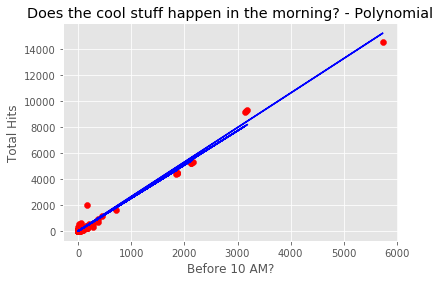

In [124]:
def viz_poly():
    plt.scatter(X_train, y_train, color='red')
    plt.plot(X_train, y_poly_pred, color='blue')
    plt.title('Does the cool stuff happen in the morning? - Polynomial')
    plt.xlabel('Before 10 AM?')
    plt.ylabel('Total Hits')
    plt.show()
    return
viz_poly()

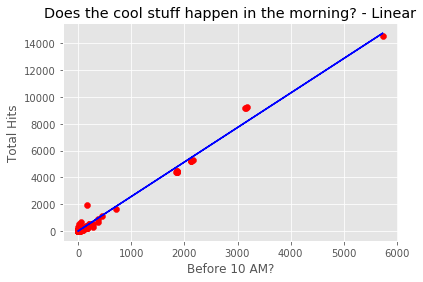

In [125]:
# Fitting Linear Regression to the dataset
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Visualizing the Linear Regression results
def viz_linear():
    plt.scatter(X_train, y_train, color='red')
    plt.plot(X_train, lin_reg.predict(X_train), color='blue')
    plt.title('Does the cool stuff happen in the morning? - Linear')
    plt.xlabel('Before 10 AM?')
    plt.ylabel('Total Hits')
    plt.show()
    return
viz_linear()

In [126]:
## imports
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import itertools
import scipy.stats as stats
#from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score


import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [131]:
km = KMeans(n_clusters=3, max_iter=100)
y_kmeans = km.fit_predict(X_train)
centriods = km.cluster_centers_

Text(0, 0.5, 'Total Daily Hits')

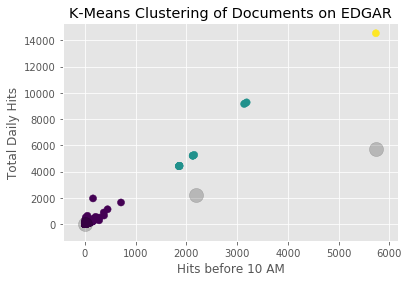

In [132]:
plt.scatter(X_train, y_train, c=y_kmeans, s=50, cmap='viridis')

centers = km.cluster_centers_
plt.scatter(centers, centers, c='black', s=200, alpha=0.2)
plt.title("K-Means Clustering of Documents on EDGAR")
plt.xlabel("Hits before 10 AM")
plt.ylabel("Total Daily Hits")

In [ ]:
#works because not complicated

In [ ]:
# from sklearn.metrics import confusion_matrix
# import seaborn as sns
# mat = confusion_matrix(y_kmeans, y_train)
# sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
#             xticklabels=docnames,
#             yticklabels=docnames)
# plt.xlabel('true label')
# plt.ylabel('predicted label');

In [133]:
score = silhouette_score(X_train, y_kmeans)
print("For n_clusters = {}, silhouette score is {})".format(3, score))

For n_clusters = 3, silhouette score is 0.9993056083875234)


In [66]:
#ROC Curve

In [70]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]



# calculate scores
#ns_auc = roc_auc_score(y_test, ns_probs)
pr_auc = roc_auc_score(y_test, y_poly_pred)
km_auc = roc_auc_score(y_test, y_kmeans)
# summarize scores
#print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Polynomial: ROC AUC=%.3f' % (pr_auc))
print('KMeans-Clustering: ROC AUC=%.3f' % (km_auc))
# calculate roc curves
#ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
pr_fpr, pr_tpr, _ = roc_auc_curve(y_test, pr_probs)
km_fpr, km_tpr, _ = roc_auc_curve(y_test, km_probs)

# plot the roc curve for the model
#pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(pr_fpr, pr_tpr, marker='.', label='Polynomial')
pyplot.plot(km_fpr, km_tpr, marker='^', label='KMeans')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

ValueError: multi_class must be in ('ovo', 'ovr')